# Network Model

`2018-02-12`

`Richard Podkolinski`

## Introduction
How do we simulate binary choices in a network?

### Problem Statement
We are interested in simulating the dispersion of a meme through a network. Specifically we are interested in whether or not an individual within the network accepts or rejects a particular meme (our change management strategy for example) after repeated exposure from others about that meme. To that end, we build a simple Beta distributed network model. This document covers the basics necessary to understand the simulation model.


### Bayes' Rule and Bayesian Updating


#### Basics and Notation
(Notation explanation entirely lifted from Gelman et al. 2013)

Let $y$ be a set of observed data values, while $\theta$ is a set of unobserved data, also known as parameters.

To make probability statements about $\theta$ given $y$, we must begin with a model providing the joint probability distribution for $\theta$ and $y$. This joint density can be written as the productof two densities referred to as the prior distribution, $p(\theta)$, and the data distribution, $p(y|\theta)$, such that: $p(\theta, y) = p(\theta)p(y|\theta)$.

We can condition this distribution based on the data, $y$ in the following manner:

$$p(\theta|y) = \frac{p(\theta,y)}{p(y)} = \frac{p(\theta)p(y|\theta)}{p(y)}$$

where $p(y) = \sum_\theta p(\theta)p(y|\theta)$ or simply the sum over all possible values of $\theta$. This value is constant, but necessary to transform the value back into a probability mapped on the $[0,1]$ range. However, for ease of understanding it is possible to provide an unnormalized version of the above:

$$p(\theta|y) \propto p(\theta) p(y|\theta) $$

This can be read, the probability of our unobserved data is proportional to our prior knowledge multiplied by the probability of our data given our parameters.

Every interaction within this simulation will be underpinned by this Bayesian construction.


#### Beta Distribution
At the kernel of our engine will be the Beta Distribution, a continuous probability distribution with a support at $[0,1]$ that is incredibly useful in modeling subjective degrees of belief about binary outcomes. 

It has a probability density of:

$$B(\alpha, \beta) = p(\theta|\alpha, \beta) = \theta^{\alpha-1} (1-\theta)^{\beta-1} \cdot \text{Beta}(\alpha,\beta) $$

Where $\alpha > 0, \beta > 0$ and $\text{Beta}(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$

So how do we use this to model belief about a binary outcome?



###### Footnote: We can ignore the $\text{Beta}(\alpha,\beta)$, also known as the Beta function, as it only serves to normalize the density to the $[0,1]$ range. Also, the Beta function $\text{Beta}(\alpha, \beta) \ne B(\alpha, \beta)$ and the Beta distribution are different things (I did not make this naming convention ;____;), the Beta function can very roughly be thought of as the ratio of possible events to total events, serving a similar purpose as the factorial, $\binom{n}{k}$ in the binomial. 




### Modelling Belief

Let's model a state of ignorance to examine how this distribution works.

We'll use a $B(1,1)$ as the basis of this state of ignorance, and we'll plot the underlying distribution.

In [33]:
import numpy as np
import scipy as sp
from scipy.stats import beta
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
plt.style.use('ggplot')
rcParams['figure.figsize'] = 10, 5

def plot_beta(a, b, title=""):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(0.01, 0.99, 100)
    ax.plot(x, beta.pdf(x, a,b), 'r-', lw=2, alpha=0.6, label='beta pdf')
    #mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    plt.title(title)
    plt.ylabel("Density")
    plt.xlabel(r'$\theta$ = Support')

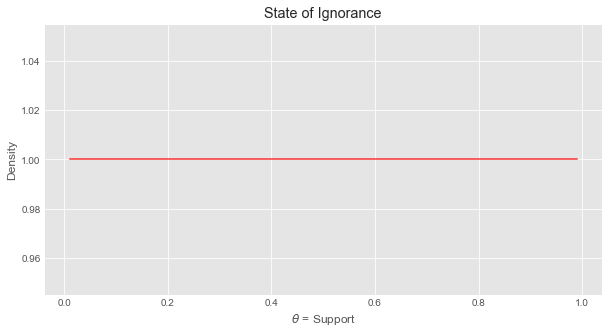

In [34]:
plot_beta(1,1, "State of Ignorance")

The axes can be interpreted the following way: 
- The horizontal axis represents the support for a particular idea/meme/change, with 0 implying a complete resistance, 0.5 indifference and 1 complete acceptance. Stated different, 0 implies you'll actively fight against the idea, 1 implies you'll actively support the idea, 0.5 implies your indifferent. 
- The vertical axis represents the density (or weight) of support at any specific value


The above plot demonstrates a state of complete ignorance, whereby an individual assigns equal weight to rejecting or accepting the idea at any degree of support.

Let's say we want to represent someone that largely accepts the meme, but still has a degree of uncertainty associated with their beliefs. The Beta will facilitate this as well.

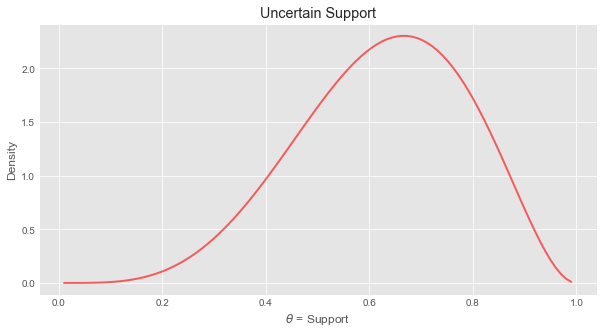

In [35]:
plot_beta(5,3, "Uncertain Support")

Note that the only thing we changed to create this new shape were the $\alpha$ and $\beta$ parameters of this distribution. 

In this case, $B(5,3)$ can be used to define an individual who has moderate but uncertain support. As we can see the majority of the area is greater than 0.5, suggesting support, but it is still broadly spread out, with some of that area (roughly ${\frac{1}{3}}$rd) still below 0.5.

We can contrast that with the plot below:

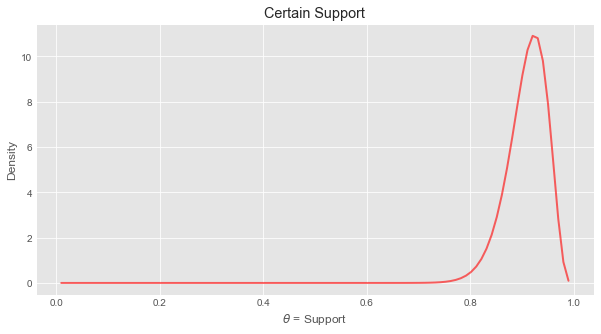

In [47]:
plot_beta(50,5, "Certain Support")

In the above plot $B(50,5)$ is used, and it clear this individual overwhelmingly supports as the majority of the density is found near 1 and none of it is below 0.5.

In [48]:
beta.cdf(0.5, 50, 5)

1.9014845253906294e-11

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R require(ggplot2); require(tidyr)

### Free Writing Section

So what do I need to explain model this model?
- Beta Distribution ✔
- Basic descriptions of supports ✔
- "Garden of Forking Paths" explanation of Beta construction
- How communication works, discrete markov model?

Added Complexities
- Increase Communication Frequency depending on the strength of belief
- People who are further from 0.5 will communicate more often
- Create a zone of indifference parameter a variable bound on $[0,1]$. For example, if indifference = 0.5, then the quantile of [0.25,0.75]. The probability of communication excludes this deadzone from a determination of communication at any given time.
----------------
----------------